In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq

import matplotlib.pyplot as plt

def polaritons(wz, wc, lam):
    def para(wz, wc, lam):
        innerroot = np.sqrt(wz**4 + wc**4 - 2*wz**2*wc**2 + 16*lam**2*wz*wc)
        return np.sqrt(0.5 * (wz**2 + wc**2 - innerroot)), np.sqrt(0.5 * (wz**2 + wc**2 + innerroot))
    
    def ferro(wz, wc, lam):
        mu = wz * wc / (4 * lam**2)
        g = lam * mu * np.sqrt(2 / (1 + mu))
        wztilde = wz * (1 + mu) / (2 * mu)
        eps = wz * (1 - mu) * (3 + mu) / (8 * mu * (1 + mu))
        
        innerroot = np.sqrt(wztilde**4 + wc**4 - 2*wztilde**2*wc**2 + 16*g**2*wztilde*wc + 4*(eps**2*wztilde**2 + eps*wztilde**3 - wc**2*eps*wztilde))
        return np.sqrt(0.5 * (wztilde**2 + wc**2 + 2*eps*wztilde - innerroot)), np.sqrt(0.5 * (wztilde**2 + wc**2 + 2*eps*wztilde + innerroot))
    
    if 4 * lam**2 < wz * wc:
        # paramagnetic phase
        return para(wz, wc, lam)
    else:
        # ferromagnetic phase
        return ferro(wz, wc, lam)
    
def polaritons_local(wz, wc, lam):
    if 4 * lam**2 < wz * wc:
        root = np.sqrt(0.25*(wz - wc)**2 + lam**2)
        return 0.5*(wz + wc) - root, 0.5*(wz + wc) + root
    else:
        raise ValueError('This function only works in the paramagnetic phase.')

def LLG(t, m, Beff, gammaLL, alpha):
    return -gammaLL * (np.cross(m, Beff) + alpha*np.cross(m, np.cross(m, Beff))) / (1 + alpha**2)

def LLG_memory_OUTDATED(t, m, Bext, Brms, wc, N, dt, gammaLL, alpha):
    LLG_memory.S += np.sin(wc * t) * np.dot(Brms, m) * dt
    LLG_memory.C += np.cos(wc * t) * np.dot(Brms, m) * dt
    G = -gammaLL*N / (2 * np.pi) * (np.cos(wc * t)*LLG_memory.S - np.sin(wc * t)*LLG_memory.C) 
    Beff = Bext + Brms*G
    return -gammaLL * (np.cross(m, Beff) + alpha*np.cross(m, np.cross(m, Beff))) / (1 + alpha**2)

def LLG_memory(t, m, Bext, Brms, wc, N, gammaLL, alpha):
    dt = t - LLG_memory.last_t
    LLG_memory.S += np.sin(wc * t) * np.dot(Brms, m) * dt
    LLG_memory.C += np.cos(wc * t) * np.dot(Brms, m) * dt
    G = -gammaLL*N * (np.cos(wc * t)*LLG_memory.S - np.sin(wc * t)*LLG_memory.C) # /(2 * np.pi)
    Beff = Bext + Brms*G
    LLG_memory.last_t = t
    return -gammaLL * (np.cross(m, Beff) + alpha*np.cross(m, np.cross(m, Beff))) / (1 + alpha**2)

def LLG_memory_cavdis(t, m, Bext, Brms, wc, kappa, N, gammaLL, alpha):
    dt = t - LLG_memory.last_t
    LLG_memory.S += np.exp(kappa * t) * np.sin(wc * t) * np.dot(Brms, m) * dt
    LLG_memory.C += np.exp(kappa * t) * np.cos(wc * t) * np.dot(Brms, m) * dt
    G = -gammaLL*N * np.exp(-kappa * t) * (np.cos(wc * t)*LLG_memory.S - np.sin(wc * t)*LLG_memory.C) # /(2 * np.pi)
    Beff = Bext + Brms*G
    LLG_memory.last_t = t
    return -gammaLL * (np.cross(m, Beff) + alpha*np.cross(m, np.cross(m, Beff))) / (1 + alpha**2)

def LLG_explicit_real(t, mxp, Bext, Brms, wc, kappa, N, gammaLL, alpha):
    m = mxp[:-2]
    xp = mxp[-2:]
    
    Beff = Bext + Brms*xp[0]
    dm = -gammaLL * (np.cross(m, Beff) + alpha*np.cross(m, np.cross(m, Beff))) / (1 + alpha**2)
    
    M = np.array([[-kappa, -wc],
                 [wc, -kappa]])
    dxp = np.dot(M, xp)
    dxp[1] += -N * gammaLL * np.dot(Brms, m)
    
    return np.append(dm, dxp)

def cavity_real(t, xp, wc, kappa):
    M = np.array([[-kappa, -wc],
                 [wc, -kappa]])
    
    return np.dot(M, xp)

def LLG_explicit_local(t, mxp, wz, lam, wc, kappa, N, eta1, eta2):
    m = mxp[:-2]
    xp = mxp[-2:]
        
    Bext = np.array([0, 0, wz])
    Brms = np.array([2 * lam / np.sqrt(N), 0, 0])
    Beff = Bext + Brms*xp[0]
    dm = -np.cross(m, Beff) - m*np.array([eta1, eta1, eta2])
    dm[2] += eta2
    
    M = np.array([[-kappa, -wc],
                 [wc, -kappa]])
    dxp = np.dot(M, xp)
    dxp[1] += -N * np.dot(Brms, m)
    return np.append(dm, dxp)

def LLG_explicit_local_super(t, mxp, wz, lam, wc, kappa, N, eta1, eta2):
    m = mxp[:-2]
    xp = mxp[-2:]
        
    Bext = np.array([0, 0, wz])
    Brms = np.array([2 * lam / np.sqrt(N), 0, 0])
    Beff = Bext + Brms*xp[0]
    dm = -np.cross(m, Beff) - m*np.array([eta1, eta1, eta2])
    dm[0] += eta1
    
    M = np.array([[-kappa, -wc],
                 [wc, -kappa]])
    dxp = np.dot(M, xp)
    dxp[1] += -N * np.dot(Brms, m)
    return np.append(dm, dxp)
    


# Benchmark 1: Original LLG (only spin), should be equivalent to default Mumax3

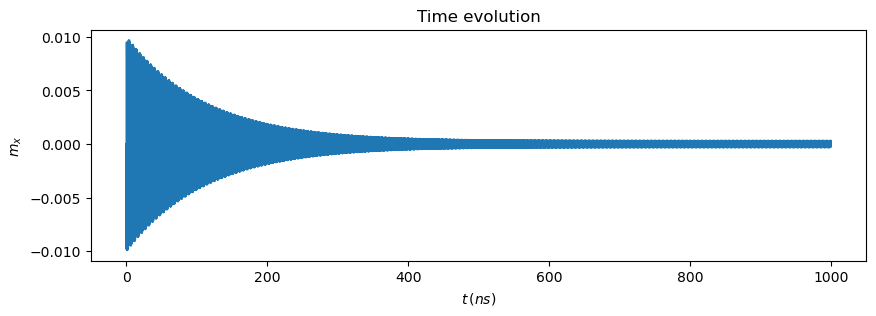

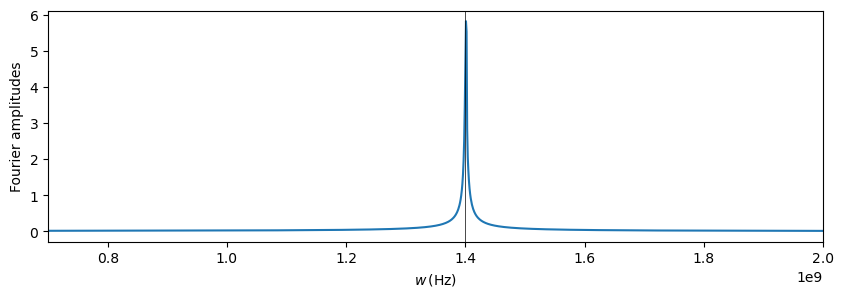

In [2]:
plt.rcParams['figure.figsize'] = (10, 3)

N = 100
tmax = 1000e-9
alpha = 1e-3
my0 = 0.01
m0 = np.array([0, my0, np.sqrt(1 - my0**2)])
gammaLL = 28e9 * 2*np.pi
wz = 1.4e9
Beff = np.array([0, 0, 2*np.pi*wz/gammaLL])
t_eval = np.linspace(0, tmax, 10000)
sol = solve_ivp(LLG, (0, tmax), m0, args=(Beff, gammaLL, alpha), t_eval=t_eval)
ws = fftfreq(len(sol.t), sol.t[1] - sol.t[0])
amps = np.abs(fft(sol.y[0]))

plt.plot(sol.t * 1e9, sol.y[0])
plt.ylabel(r'$m_x$')
plt.xlabel(r'$t \, (ns)$')
plt.title('Time evolution')
plt.show()
plt.plot(ws[:len(ws)//2], amps[:len(ws)//2])
plt.xlim(0.7e9, 2e9)
plt.ylabel('Fourier amplitudes')
plt.xlabel(r'$w \, ({\rm Hz})$')
plt.axvline(1.4e9, c='k', lw=0.5)
plt.show()

# Benchmark 2: Evolution of a cavity

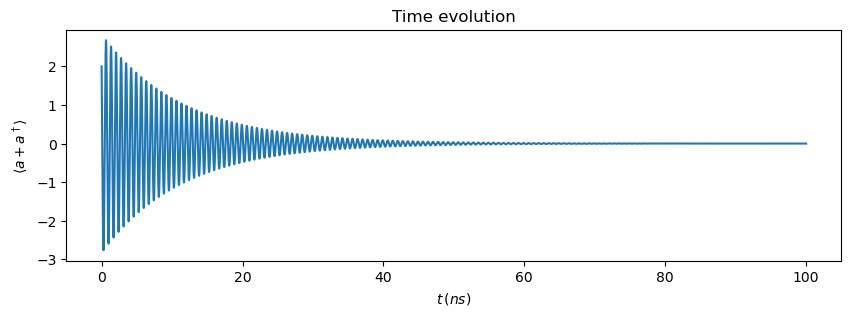

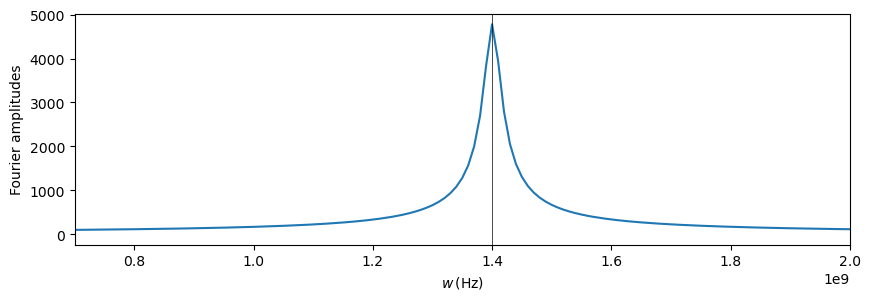

In [3]:

tmax = 100e-9

m0 = np.array([2, 2])
wc = 1.4e9 * 2*np.pi
kappa = 0.01 * wc

t_eval = np.linspace(0, tmax, 30000)
sol = solve_ivp(cavity_real, (0, tmax), m0, args=(wc, kappa), t_eval=t_eval)#, max_step=dt, atol = 1, rtol = 1
ws = fftfreq(len(sol.t), sol.t[1] - sol.t[0])
amps = np.abs(fft(sol.y[0]))
plt.plot(sol.t * 1e9, sol.y[0])
plt.ylabel(r'$\langle a + a^\dagger \rangle$')
plt.xlabel(r'$t \, (ns)$')
plt.title('Time evolution')
plt.show()
plt.plot(ws[:len(ws)//2], amps[:len(ws)//2])
plt.xlim(0.7e9, 2e9)
plt.axvline(1.4e9, c='k', lw=0.5)
plt.ylabel('Fourier amplitudes')
plt.xlabel(r'$w \, ({\rm Hz})$')
plt.show()



# Explicit solution of spin + cavity system (explicit equations of motion for both spin and cavity DOFs)

wzc/wc: 0.7466910823080258


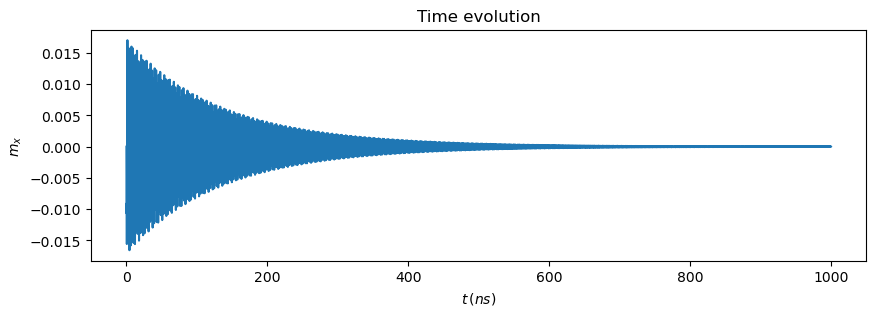

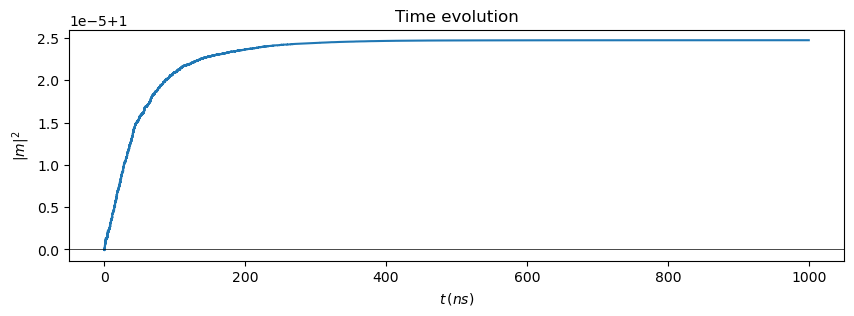

gap/lam: 1.153433211418139


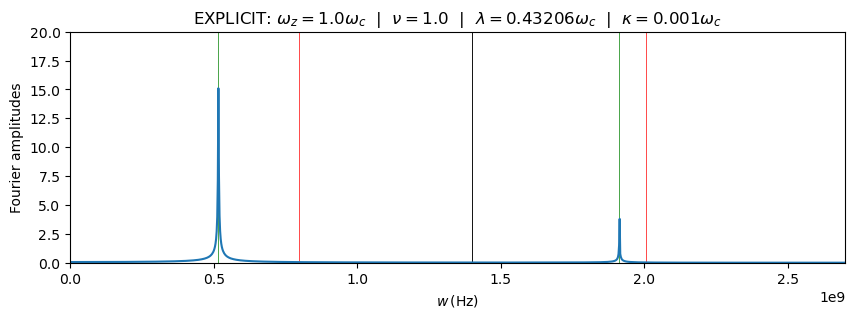

In [4]:

N = 1000
tmax = 1000e-9 #1000
alpha = 1e-3
my0 = 0.01
m0 = np.array([0, my0, np.sqrt(1 - my0**2), 0, 0])
gammaLL = 28e9 * 2*np.pi
wc = 1.4e9
wz = 1 * wc
kappa = 0.001 * wc
Bext = np.array([0, 0, 2*np.pi*wz/gammaLL])
nu = 1.0
c = 5.124350564859e-19
rho = 5.1e26 # densidad espines FIJA
lam = np.sqrt(c * rho * nu * wc)
Brms = 4 * np.pi * lam / (np.sqrt(N) * gammaLL)
Brms = np.array([Brms, 0, 0])
wzc = 4 * lam ** 2 / wc # freq espines critica, calculo indicativo
print('wzc/wc:', wzc / wc)

t_eval = np.linspace(0, tmax, 500000) #100000
#dt = 0.01e-9
sol = solve_ivp(LLG_explicit_real, (0, tmax), m0, method='RK45', args=(Bext, Brms, 2*np.pi * wc, 2*np.pi * kappa, N, gammaLL, alpha), t_eval=t_eval)#, max_step=dt, atol = 1, rtol = 1
ws = fftfreq(len(sol.t) // 2, sol.t[1] - sol.t[0]) # discard first half of time evolution
amps = np.abs(fft(sol.y[0][len(sol.t) // 2:])) # discard first half of time evolution
plt.plot(sol.t * 1e9, sol.y[0])

#plt.xlim(0, 50)
plt.ylabel(r'$m_x$')
plt.xlabel(r'$t \, (ns)$')
plt.title('Time evolution')
plt.show()


plt.plot(sol.t * 1e9, [mx**2 + my**2 + mz**2 for mx, my, mz in zip(sol.y[0], sol.y[1], sol.y[2])])
plt.axhline(1.0, c='k', lw=0.5)
#plt.ylim(0, 1.1)
plt.ylabel(r'$|m|^2$')
plt.xlabel(r'$t \, (ns)$')
plt.title('Time evolution')
plt.show()

plt.axvline(wc, c='k',lw=0.5)
plt.axvline(wz, c='k',lw=0.5)

# AQUI SE CALCULAN Y PINTAN LOS POLARITONES
pm, pp = polaritons(wz, wc, lam)
for p in (pm, pp):
    plt.axvline(p, c='g', lw=0.5)
# -----------------------------------------

print('gap/lam:', (pp - pm) / (2 * lam)) 

# AQUI SE CALCULAN Y PINTAN OTROS POLARITONES
pm, pp = polaritons_local(wz, wc, lam)
for p in (pm, pp):
    plt.axvline(p, c='r', lw=0.5)
# -----------------------------------------
plt.plot(ws[:len(ws)//2], amps[:len(ws)//2])
#plt.xlim(0.1e9, 2e9)
plt.ylim(0, 20)
plt.xlim(0.0e9, 2.7e9)
plt.ylabel('Fourier amplitudes')
plt.xlabel(r'$w \, ({\rm Hz})$')
plt.title('EXPLICIT: ' + rf'$\omega_z = {wz / wc} \omega_c$' + '  |  ' + rf'$\nu = {nu}$' + '  |  ' + rf'$\lambda = {round(lam/wc, 5)} \omega_c$' + '  |  ' + rf'$\kappa = {round(kappa/wc, 5)} \omega_c$')

plt.show()



# Implicit solution of spin + cavity system (cavity DOFs integrated out), should be equivalent to modified Mumax3

[0.    0.    0.015]
[0.00136628 0.         0.        ]
[0.000000e+00 2.000004e-03 4.000008e-03 ... 9.999960e+02 9.999980e+02
 1.000000e+03]


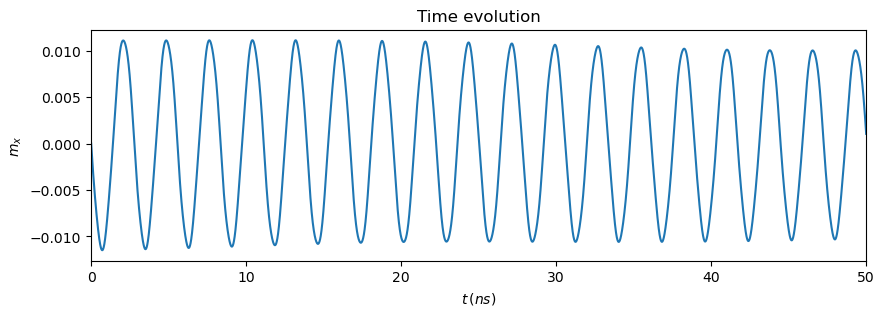

gap/lam: 2.762918146249886


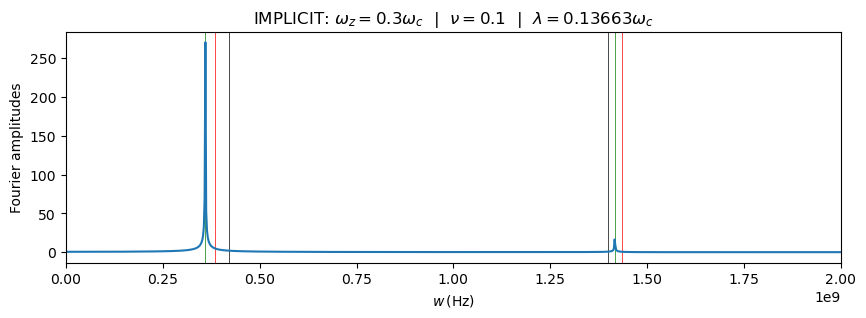

In [5]:
N = 100
tmax = 1000e-9 #1000
alpha = 1e-3
my0 = 0.01
m0 = np.array([0, my0, np.sqrt(1 - my0**2)])
gammaLL = 28e9 * 2*np.pi
wc = 1.4e9
wz = 0.3 * wc
Bext = np.array([0, 0, 2*np.pi*wz/gammaLL])
nu = 0.1
c = 5.124350564859e-19
rho = 5.1e26 # densidad espines FIJA 
lam = np.sqrt(c * rho * nu * wc)
Brms = 4 * np.pi * lam / (np.sqrt(N) * gammaLL)
Brms = np.array([Brms, 0, 0])
print(Bext)
print(Brms)

t_eval = np.linspace(0, tmax, 500000) #100000
print(t_eval * 1e9)
dt = 0.01e-9
LLG_memory.S = 0
LLG_memory.C = 0
LLG_memory.last_t = 0.0
sol = solve_ivp(LLG_memory, (0, tmax), m0, method='RK45', args=(Bext, Brms, 2*np.pi * wc, N, gammaLL, alpha), t_eval=t_eval, max_step=dt, atol = 1, rtol = 1)
ws = fftfreq(len(sol.t) // 2, sol.t[1] - sol.t[0]) # discard first half of time evolution
amps = np.abs(fft(sol.y[0][len(sol.t) // 2:])) # discard first half of time evolution
plt.plot(sol.t * 1e9, sol.y[0])
plt.xlim(0, 50)
plt.ylabel(r'$m_x$')
plt.xlabel(r'$t \, (ns)$')
plt.title('Time evolution')
plt.show()
plt.axvline(wc, c='k',lw=0.5)
plt.axvline(wz, c='k',lw=0.5)

# AQUI SE CALCULAN Y PINTAN LOS POLARITONES
pm, pp = polaritons(wz, wc, lam)
for p in (pm, pp):
    plt.axvline(p, c='g', lw=0.5)
# -----------------------------------------

print('gap/lam:', (pp - pm) / (2 * lam)) 

# AQUI SE CALCULAN Y PINTAN OTROS POLARITONES
pm, pp = polaritons_local(wz, wc, lam)
for p in (pm, pp):
    plt.axvline(p, c='r', lw=0.5)
# -----------------------------------------
plt.plot(ws[:len(ws)//2], amps[:len(ws)//2])
#plt.xlim(0.1e9, 2e9)
#plt.ylim(0, 1e-10)
plt.xlim(0.0e9, 2e9)
plt.ylabel('Fourier amplitudes')
plt.xlabel(r'$w \, ({\rm Hz})$')
plt.title('IMPLICIT: ' + rf'$\omega_z = {wz / wc} \omega_c$' + '  |  ' + rf'$\nu = {nu}$' + '  |  ' + rf'$\lambda = {round(lam/wc, 5)} \omega_c$')

plt.show()



# A comparison of explicit vs implicit

[0.   0.   0.05]
[0.0030551 0.        0.       ]


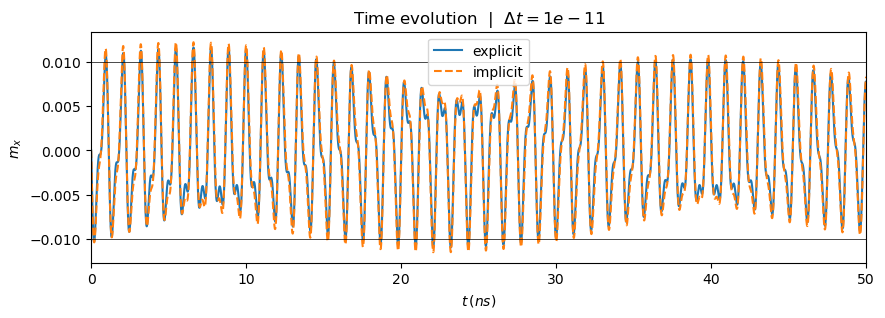

In [6]:

N = 100
tmax = 1000e-9 #1000
alpha = 1e-3
my0 = 0.01
m0 = np.array([0, my0, np.sqrt(1 - my0**2), 0, 0])
gammaLL = 28e9 * 2*np.pi
wc = 1.4e9
wz = 1 * wc
kappa = 0.00 * wc
Bext = np.array([0, 0, 2*np.pi*wz/gammaLL])
nu = 0.5
c = 5.124350564859e-19
rho = 5.1e26 # densidad espines FIJA
lam = np.sqrt(c * rho * nu * wc)
Brms = 4 * np.pi * lam / (np.sqrt(N) * gammaLL)
Brms = np.array([Brms, 0, 0])
print(Bext)
print(Brms)

t_eval = np.linspace(0, tmax, 500000) #100000
#dt = 0.01e-9
#dt = 0.01e-9
sol = solve_ivp(LLG_explicit_real, (0, tmax), m0, args=(Bext, Brms, 2*np.pi * wc, 2*np.pi * kappa, N, gammaLL, alpha), t_eval=t_eval)#, max_step=dt, atol = 1, rtol = 1
ws = fftfreq(len(sol.t) // 2, sol.t[1] - sol.t[0]) # discard first half of time evolution
amps = np.abs(fft(sol.y[0][len(sol.t) // 2:])) # discard first half of time evolution
plt.plot(sol.t * 1e9, sol.y[0], label='explicit')

m0 = np.array([0, my0, np.sqrt(1 - my0**2)])
dt = 0.01e-9
LLG_memory.S = 0
LLG_memory.C = 0
LLG_memory.last_t = 0.0
sol = solve_ivp(LLG_memory, (0, tmax), m0, args=(Bext, Brms, 2*np.pi * wc, N, gammaLL, alpha), t_eval=t_eval, max_step=dt, atol = 1, rtol = 1)
plt.plot(sol.t * 1e9, sol.y[0], ls='dashed', label='implicit')

m0 = np.array([0, my0, np.sqrt(1 - my0**2), 0, 0])
eta1 = 0.001 * wz
eta2 = 0.001 * wz
sol = solve_ivp(LLG_explicit_local, (0, tmax), m0, args=(2*np.pi * wz, 2*np.pi * lam, 2*np.pi * wc, 2*np.pi * kappa, N, 2*np.pi * eta1, 2*np.pi * eta2), t_eval=t_eval)#, max_step=dt, atol = 1, rtol = 1
#plt.plot(sol.t * 1e9, sol.y[0], ls='dotted', label='explicit local')

plt.xlim(0, 50)
plt.ylabel(r'$m_x$')
plt.xlabel(r'$t \, (ns)$')
plt.title('Time evolution' + '  |  ' + rf'$\Delta t = {dt}$')
plt.axhline(my0, c='k', lw='0.5')
plt.axhline(-my0, c='k', lw='0.5')
plt.legend()
plt.show()




# Explicit solution of Heisenberg Eqs of motion with phenomenological dissipation (local master equation style)

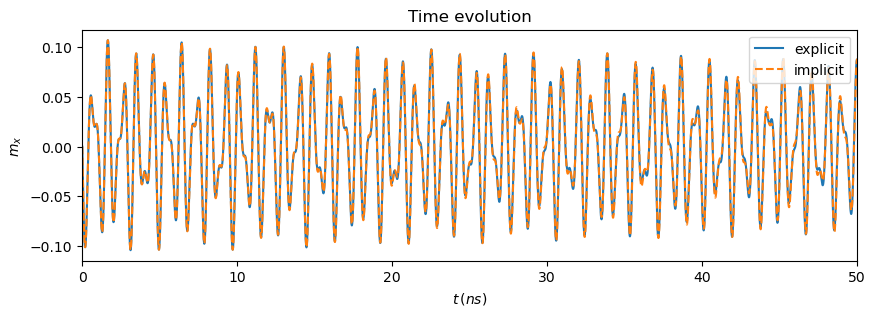

gap/lam: 1.025480152774383


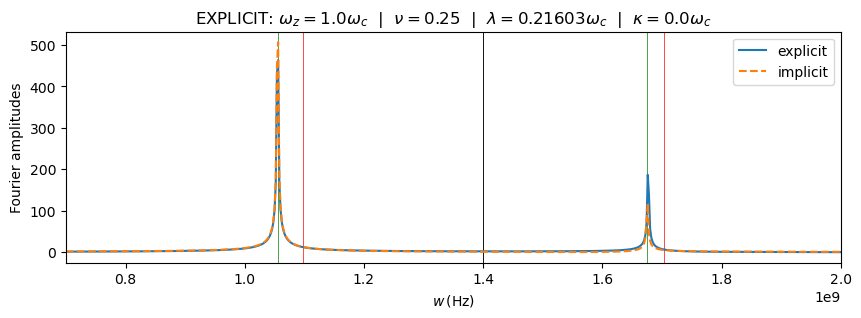

In [7]:

N = 1
tmax = 1000e-9 #1000
alpha = 1e-3
gammaLL = 28e9 * 2*np.pi
my0 = 0.1
m0 = np.array([0, my0, np.sqrt(1 - my0**2), 0, 0])
wc = 1.4e9
wz = 1 * wc
kappa = 0.00 * wc
eta1 = 0.001 * wz
eta2 = 0.002 * wz
Bext = np.array([0, 0, 2*np.pi*wz/gammaLL])
nu = 0.25
c = 5.124350564859e-19
rho = 5.1e26 # densidad espines FIJA
lam = np.sqrt(c * rho * nu * wc)
Brms = 4 * np.pi * lam / (np.sqrt(N) * gammaLL)
Brms = np.array([Brms, 0, 0])

t_eval = np.linspace(0, tmax, 500000) #100000
#dt = 0.01e-9
sol_local = solve_ivp(LLG_explicit_local, (0, tmax), m0, args=(2*np.pi * wz, 2*np.pi * lam, 2*np.pi * wc, 2*np.pi * kappa, N, 2*np.pi * eta1, 2*np.pi * eta2), t_eval=t_eval)#, max_step=dt, atol = 1, rtol = 1
ws_local = fftfreq(len(sol_local.t) // 2, sol_local.t[1] - sol_local.t[0]) # discard first half of time evolution
amps_local = np.abs(fft(sol_local.y[0][len(sol_local.t) // 2:])) # discard first half of time evolution

sol = solve_ivp(LLG_explicit_real, (0, tmax), m0, args=(Bext, Brms, 2*np.pi * wc, 2*np.pi * kappa, N, gammaLL, alpha), t_eval=t_eval)#, max_step=dt, atol = 1, rtol = 1
ws = fftfreq(len(sol.t) // 2, sol.t[1] - sol.t[0]) # discard first half of time evolution
amps = np.abs(fft(sol.y[0][len(sol.t) // 2:])) # discard first half of time evolution

m0 = np.array([0, my0, np.sqrt(1 - my0**2)])
dt = 0.01e-9
LLG_memory.S = 0
LLG_memory.C = 0
LLG_memory.last_t = 0.0
sol_implicit = solve_ivp(LLG_memory, (0, tmax), m0, method='RK45', args=(Bext, Brms, 2*np.pi * wc, N, gammaLL, alpha), t_eval=t_eval, max_step=dt, atol = 1, rtol = 1)
ws_implicit = fftfreq(len(sol_implicit.t) // 2, sol_implicit.t[1] - sol_implicit.t[0]) # discard first half of time evolution
amps_implicit = np.abs(fft(sol_implicit.y[0][len(sol_implicit.t) // 2:])) # discard first half of time evolution

plt.plot(sol.t * 1e9, sol.y[0], label='explicit')
plt.plot(sol_implicit.t * 1e9, sol_implicit.y[0], ls='dashed', label='implicit')
#plt.plot(sol_local.t * 1e9, sol_local.y[0], ls='dotted', label='local dissipation')
plt.xlim(0, 50)
plt.ylabel(r'$m_x$')
plt.xlabel(r'$t \, (ns)$')
plt.title('Time evolution')
plt.legend()
plt.show()
plt.axvline(wc, c='k',lw=0.5)
plt.axvline(wz, c='k',lw=0.5)

# AQUI SE CALCULAN Y PINTAN LOS POLARITONES
pm, pp = polaritons(wz, wc, lam)
for p in (pm, pp):
    plt.axvline(p, c='g', lw=0.5)
# -----------------------------------------

print('gap/lam:', (pp - pm) / (2 * lam)) 

# AQUI SE CALCULAN Y PINTAN OTROS POLARITONES
pm, pp = polaritons_local(wz, wc, lam)
for p in (pm, pp):
    plt.axvline(p, c='r', lw=0.5)
# -----------------------------------------
plt.plot(ws[:len(ws)//2], amps[:len(ws)//2], label='explicit')
plt.plot(ws_implicit[:len(ws_implicit)//2], amps_implicit[:len(ws_implicit)//2], ls='dashed', label='implicit')
#plt.plot(ws_local[:len(ws_local)//2], amps_local[:len(ws_local)//2], ls='dotted', label='local dissipation')
#plt.xlim(0.1e9, 2e9)
#plt.ylim(0, 1e2)
plt.xlim(0.7e9, 2e9)
plt.ylabel('Fourier amplitudes')
plt.xlabel(r'$w \, ({\rm Hz})$')
plt.title('EXPLICIT: ' + rf'$\omega_z = {wz / wc} \omega_c$' + '  |  ' + rf'$\nu = {nu}$' + '  |  ' + rf'$\lambda = {round(lam/wc, 5)} \omega_c$' + '  |  ' + rf'$\kappa = {round(kappa/wc, 5)} \omega_c$')
plt.legend()
plt.show()



# Now with cavity damping

1.4


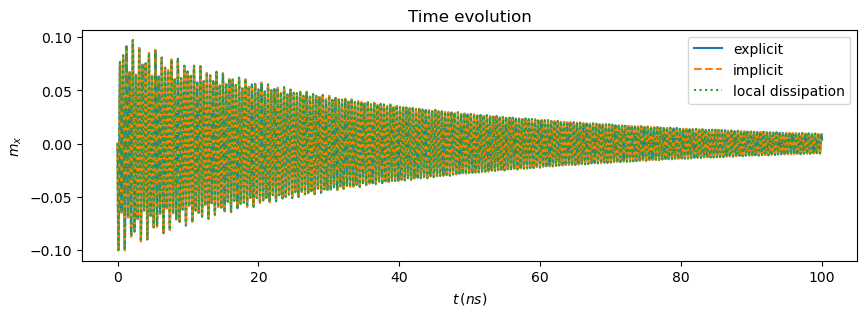

gap/lam: 1.5402775825582657


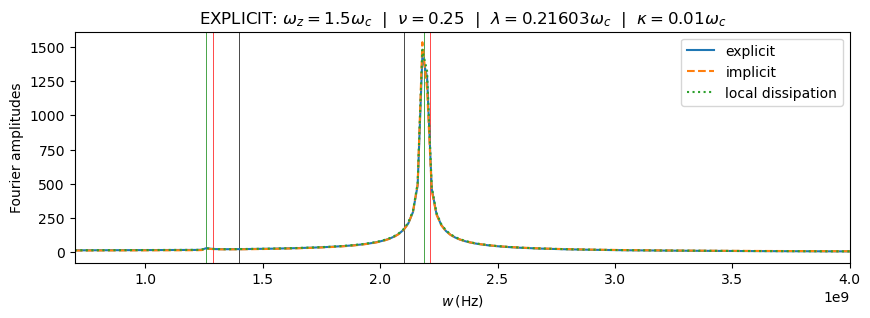

In [8]:

N = 100
tmax = 100e-9 #1000
alpha = 1e-3
gammaLL = 28e9 * 2*np.pi
my0 = 0.1
m0 = np.array([0, my0, np.sqrt(1 - my0**2), 0, 0])
wc = 1.4e9
wz = 1.5 * wc
kappa = 0.01 * wc
print(tmax * kappa)
eta1 = 0.001 * wz
eta2 = 0.002 * wz
Bext = np.array([0, 0, 2*np.pi*wz/gammaLL])
nu = 0.25
c = 5.124350564859e-19
rho = 5.1e26 # densidad espines FIJA
lam = np.sqrt(c * rho * nu * wc)
Brms = 4 * np.pi * lam / (np.sqrt(N) * gammaLL)
Brms = np.array([Brms, 0, 0])

t_eval = np.linspace(0, tmax, 500000) #100000
#dt = 0.01e-9
sol_local = solve_ivp(LLG_explicit_local, (0, tmax), m0, args=(2*np.pi * wz, 2*np.pi * lam, 2*np.pi * wc, 2*np.pi * kappa, N, 2*np.pi * eta1, 2*np.pi * eta2), t_eval=t_eval)#, max_step=dt, atol = 1, rtol = 1
ws_local = fftfreq(len(sol_local.t) // 2, sol_local.t[1] - sol_local.t[0]) # discard first half of time evolution
amps_local = np.abs(fft(sol_local.y[0][len(sol_local.t) // 2:])) # discard first half of time evolution

sol = solve_ivp(LLG_explicit_real, (0, tmax), m0, args=(Bext, Brms, 2*np.pi * wc, 2*np.pi * kappa, N, gammaLL, alpha), t_eval=t_eval)#, max_step=dt, atol = 1, rtol = 1
ws = fftfreq(len(sol.t) // 2, sol.t[1] - sol.t[0]) # discard first half of time evolution
amps = np.abs(fft(sol.y[0][len(sol.t) // 2:])) # discard first half of time evolution

m0 = np.array([0, my0, np.sqrt(1 - my0**2)])
dt = 0.01e-9
LLG_memory.S = 0
LLG_memory.C = 0
LLG_memory.last_t = 0.0
sol_implicit = solve_ivp(LLG_memory_cavdis, (0, tmax), m0, method='RK45', args=(Bext, Brms, 2*np.pi * wc, 2*np.pi * kappa, N, gammaLL, alpha), t_eval=t_eval, max_step=dt, atol = 1, rtol = 1)
ws_implicit = fftfreq(len(sol_implicit.t) // 2, sol_implicit.t[1] - sol_implicit.t[0]) # discard first half of time evolution
amps_implicit = np.abs(fft(sol_implicit.y[0][len(sol_implicit.t) // 2:])) # discard first half of time evolution

plt.plot(sol.t * 1e9, sol.y[0], label='explicit')
plt.plot(sol_implicit.t * 1e9, sol_implicit.y[0], ls='dashed', label='implicit')
plt.plot(sol_local.t * 1e9, sol_local.y[0], ls='dotted', label='local dissipation')
#plt.xlim(0, 50)
plt.ylabel(r'$m_x$')
plt.xlabel(r'$t \, (ns)$')
plt.title('Time evolution')
plt.legend()
plt.show()
plt.axvline(wc, c='k',lw=0.5)
plt.axvline(wz, c='k',lw=0.5)

# AQUI SE CALCULAN Y PINTAN LOS POLARITONES
pm, pp = polaritons(wz, wc, lam)
for p in (pm, pp):
    plt.axvline(p, c='g', lw=0.5)
# -----------------------------------------

print('gap/lam:', (pp - pm) / (2 * lam)) 

# AQUI SE CALCULAN Y PINTAN OTROS POLARITONES
pm, pp = polaritons_local(wz, wc, lam)
for p in (pm, pp):
    plt.axvline(p, c='r', lw=0.5)
# -----------------------------------------
plt.plot(ws[:len(ws)//2], amps[:len(ws)//2], label='explicit')
plt.plot(ws_implicit[:len(ws_implicit)//2], amps_implicit[:len(ws_implicit)//2], ls='dashed', label='implicit')
plt.plot(ws_local[:len(ws_local)//2], amps_local[:len(ws_local)//2], ls='dotted', label='local dissipation')
#plt.xlim(0.1e9, 2e9)
#plt.ylim(0, 1e2)
plt.xlim(0.7e9, 4e9)
plt.ylabel('Fourier amplitudes')
plt.xlabel(r'$w \, ({\rm Hz})$')
plt.title('EXPLICIT: ' + rf'$\omega_z = {wz / wc} \omega_c$' + '  |  ' + rf'$\nu = {nu}$' + '  |  ' + rf'$\lambda = {round(lam/wc, 5)} \omega_c$' + '  |  ' + rf'$\kappa = {round(kappa/wc, 5)} \omega_c$')
plt.legend()
plt.show()



# Now in the superradiant phase

wzc/wc: 0.7466910823080258


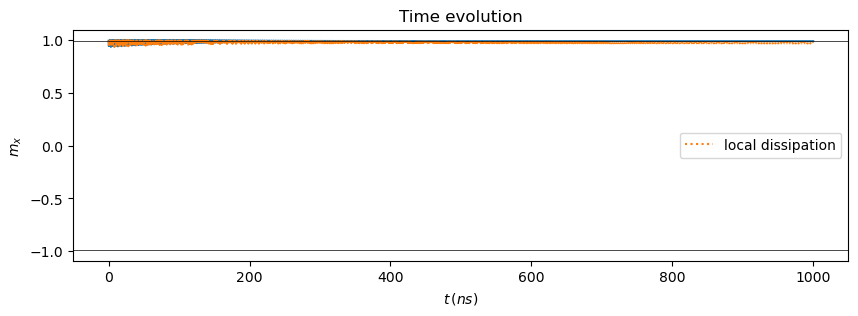

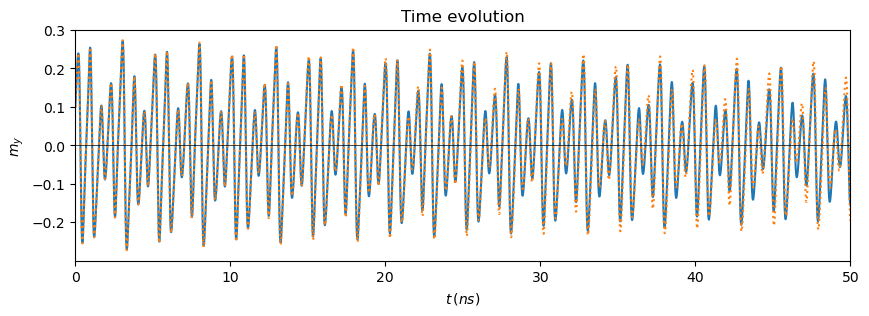

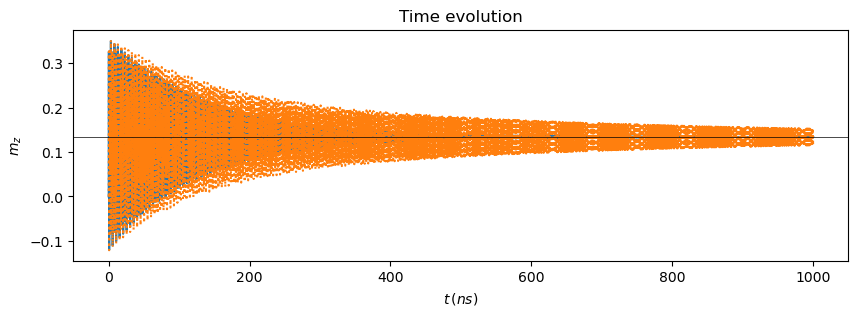

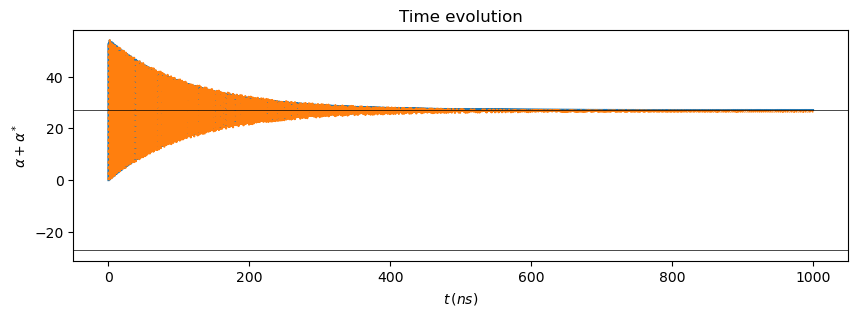

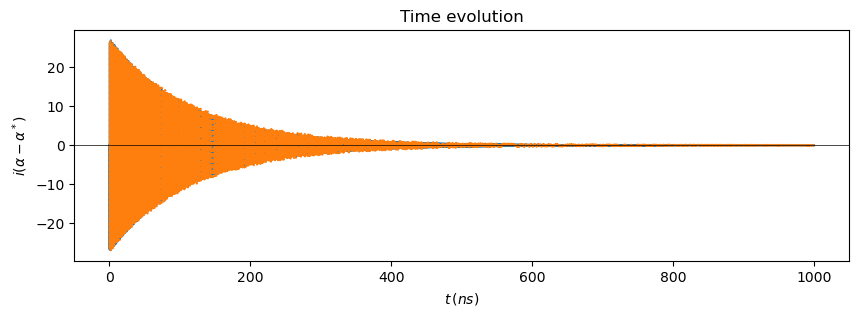

Norm deviation: 1.4194429860669988e-07
Local Norm deviation: 0.03453366246046841


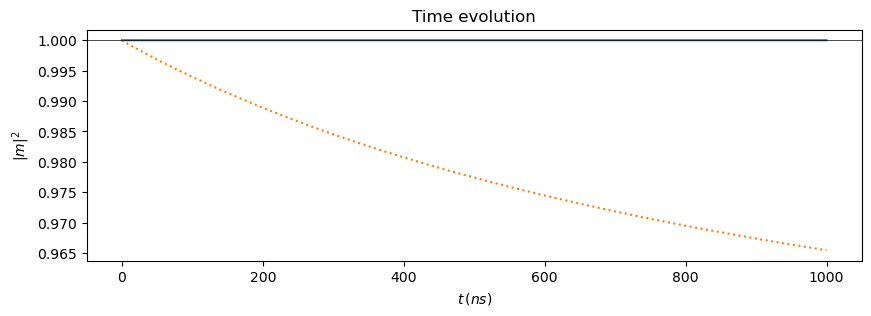

gap/lam: 0.4786622357343564


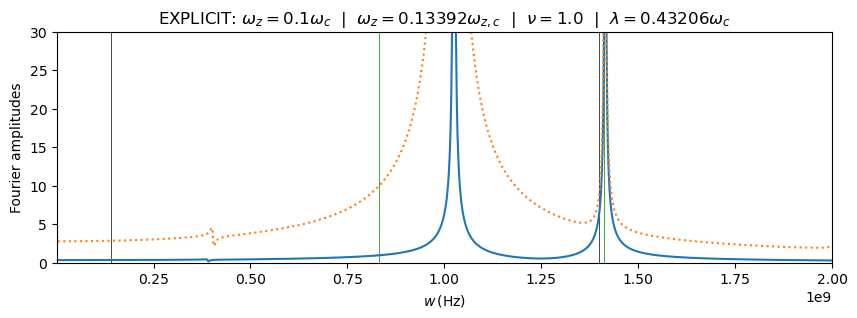

In [9]:


N = 1000
tmax = 1000e-9 #1000
alpha = 1e-3
gammaLL = 28e9 * 2*np.pi
wc = 1.4e9
wz = 0.1 * wc
kappa = 0.001 * wc
eta1 = 0.001 * wz
eta2 = 0.002 * wz
Bext = np.array([0, 0, 2*np.pi*wz/gammaLL])
nu = 1.0
c = 5.124350564859e-19
rho = 5.1e26 # densidad espines FIJA
lam = np.sqrt(c * rho * nu * wc)
Brms = 4 * np.pi * lam / (np.sqrt(N) * gammaLL)
Brms = np.array([Brms, 0, 0])
wzc = 4 * lam ** 2 / wc # freq espines critica, calculo indicativo
print('wzc/wc:', wzc / wc)
mzy = 0.01
m0 = np.array([np.sqrt(1 - my0**2), my0, 0, 0, 0]) #2*lam/wc*np.sqrt(N) * np.sqrt(1 - mz0**2)
#m0 = np.array([0, my0, np.sqrt(1 - my0**2), 0, 0]) #2*lam/wc*np.sqrt(N) * np.sqrt(1 - mz0**2)

t_eval = np.linspace(0, tmax, 500000) #100000
dt = 0.01e-9
sol = solve_ivp(LLG_explicit_real, (0, tmax), m0, method='RK45', args=(Bext, Brms, 2*np.pi * wc, 2*np.pi * kappa, N, gammaLL, alpha), max_step=dt, t_eval=t_eval)#, max_step=dt, atol = 1, rtol = 1
ws = fftfreq(len(sol.t) // 2, sol.t[1] - sol.t[0]) # discard first half of time evolution
amps = np.abs(fft(sol.y[1][len(sol.t) // 2:])) # discard first half of time evolution

dt = 0.01e-9
sol_local = solve_ivp(LLG_explicit_local_super, (0, tmax), m0, args=(2*np.pi * wz, 2*np.pi * lam, 2*np.pi * wc, 2*np.pi * kappa, N, 2*np.pi * eta1, 2*np.pi * eta2), max_step=dt, t_eval=t_eval)#, max_step=dt, atol = 1, rtol = 1
ws_local = fftfreq(len(sol_local.t) // 2, sol_local.t[1] - sol_local.t[0]) # discard first half of time evolution
amps_local = np.abs(fft(sol_local.y[1][len(sol_local.t) // 2:])) # discard first half of time evolution

plt.plot(sol.t * 1e9, sol.y[0])
plt.plot(sol_local.t * 1e9, sol_local.y[0], ls='dotted', label='local dissipation')
plt.axhline(np.sqrt(1 - (wz/wzc)**2), c='k', lw=0.5) # stationary mx
plt.axhline(-np.sqrt(1 - (wz/wzc)**2), c='k', lw=0.5) # stationary mx
#plt.axhline(wz/wzc, c='k', lw=0.5) # stationary mz
#plt.axhline(2*lam/wc*np.sqrt(N) * np.sqrt(1 - (wz/wzc)**2), c='k', lw=0.5) # stationary x
#plt.xlim(0, 50)
plt.ylabel(r'$m_x$')
plt.xlabel(r'$t \, (ns)$')
plt.title('Time evolution')
plt.legend()
plt.show()

plt.plot(sol.t * 1e9, sol.y[1])
plt.plot(sol_local.t * 1e9, sol_local.y[1], ls='dotted', label='local dissipation')
plt.axhline(0.0, c='k', lw=0.5)
plt.xlim(0, 50)
plt.ylabel(r'$m_y$')
plt.xlabel(r'$t \, (ns)$')
plt.title('Time evolution')
plt.show()


plt.plot(sol.t * 1e9, sol.y[2])
plt.plot(sol_local.t * 1e9, sol_local.y[2], ls='dotted', label='local dissipation')
#plt.axhline(np.sqrt(1 - (wz/wzc)**2), c='k', lw=0.5) # stationary mx
plt.axhline(wz/wzc, c='k', lw=0.5) # stationary mz
#plt.axhline(2*lam/wc*np.sqrt(N) * np.sqrt(1 - (wz/wzc)**2), c='k', lw=0.5) # stationary x
#plt.xlim(0, 50)
plt.ylabel(r'$m_z$')
plt.xlabel(r'$t \, (ns)$')
plt.title('Time evolution')
plt.show()

plt.plot(sol.t * 1e9, sol.y[3])
plt.plot(sol_local.t * 1e9, sol_local.y[3], ls='dotted', label='local dissipation')
#plt.axhline(np.sqrt(1 - (wz/wzc)**2), c='k', lw=0.5) # stationary mx
#plt.axhline(wz/wzc, c='k', lw=0.5) # stationary mz
plt.axhline(2*lam/wc*np.sqrt(N) * np.sqrt(1 - (wz/wzc)**2), c='k', lw=0.5) # stationary x
plt.axhline(-2*lam/wc*np.sqrt(N) * np.sqrt(1 - (wz/wzc)**2), c='k', lw=0.5) # stationary x
#plt.xlim(0, 50)
plt.ylabel(r'$\alpha + \alpha^*$')
plt.xlabel(r'$t \, (ns)$')
plt.title('Time evolution')
plt.show()

plt.plot(sol.t * 1e9, sol.y[4])
plt.plot(sol_local.t * 1e9, sol_local.y[4], ls='dotted', label='local dissipation')
plt.axhline(0.0, c='k', lw=0.5)
#plt.xlim(0, 50)
plt.ylabel(r'$i (\alpha - \alpha^*)$')
plt.xlabel(r'$t \, (ns)$')
plt.title('Time evolution')
plt.show()

plt.plot(sol.t * 1e9, [mx**2 + my**2 + mz**2 for mx, my, mz in zip(sol.y[0], sol.y[1], sol.y[2])])
plt.plot(sol_local.t * 1e9, [mx**2 + my**2 + mz**2 for mx, my, mz in zip(sol_local.y[0], sol_local.y[1], sol_local.y[2])], ls='dotted')
print(f'Norm deviation: {np.abs(1 - sol.y[0][-1]**2 - sol.y[1][-1]**2 - sol.y[2][-1]**2)}')
print(f'Local Norm deviation: {np.abs(1 - sol_local.y[0][-1]**2 - sol_local.y[1][-1]**2 - sol_local.y[2][-1]**2)}')
plt.axhline(1.0, c='k', lw=0.5)
#plt.xlim(0, 50)
plt.ylabel(r'$|m|^2$')
plt.xlabel(r'$t \, (ns)$')
plt.title('Time evolution')
plt.show()

plt.axvline(wc, c='k',lw=0.5)
plt.axvline(wz, c='k',lw=0.5)

# AQUI SE CALCULAN Y PINTAN LOS POLARITONES
pm, pp = polaritons(wz, wc, lam)
for p in (pm, pp):
    plt.axvline(p, c='g', lw=0.5)
# -----------------------------------------

print('gap/lam:', (pp - pm) / (2 * lam)) 

plt.plot(ws[:len(ws)//2], amps[:len(ws)//2])
plt.plot(ws_local[:len(ws_local)//2], amps_local[:len(ws_local)//2], ls='dotted', label='local dissipation')
#plt.xlim(0.1e9, 2e9)
plt.ylim(0, 30)
plt.xlim(0.001e9, 2e9)
plt.ylabel('Fourier amplitudes')
plt.xlabel(r'$w \, ({\rm Hz})$')
plt.title('EXPLICIT: ' + rf'$\omega_z = {wz / wc} \omega_c$' + '  |  ' + rf'$\omega_z = {round(wz / wzc, 5)} \omega_{{z, c}}$' + '  |  ' + rf'$\nu = {nu}$' + '  |  ' + rf'$\lambda = {round(lam/wc, 5)} \omega_c$')

plt.show()



wzc/wc: 0.7466910823080258
wzc/wc: 0.7466910823080258
wzc/wc: 0.7466910823080258
wzc/wc: 0.7466910823080258
wzc/wc: 0.7466910823080258
wzc/wc: 0.7466910823080258
wzc/wc: 0.7466910823080258
wzc/wc: 0.7466910823080258
wzc/wc: 0.7466910823080258
wzc/wc: 0.7466910823080258
wzc/wc: 0.7466910823080258
wzc/wc: 0.7466910823080258
wzc/wc: 0.7466910823080258
wzc/wc: 0.7466910823080258
wzc/wc: 0.7466910823080258
wzc/wc: 0.7466910823080258
wzc/wc: 0.7466910823080258
wzc/wc: 0.7466910823080258
wzc/wc: 0.7466910823080258
wzc/wc: 0.7466910823080258


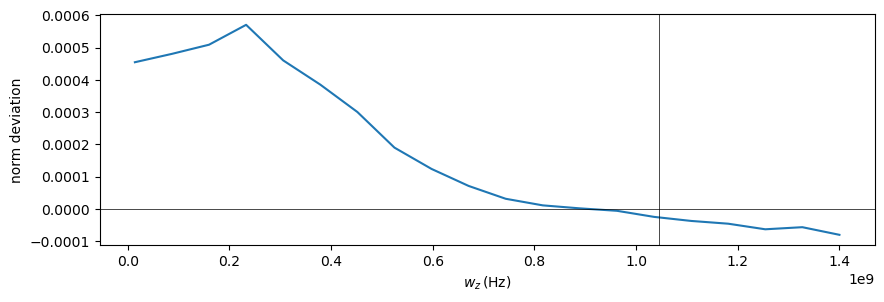

In [10]:
N = 1000
tmax = 100e-9 #1000
alpha = 1e-2
gammaLL = 28e9 * 2*np.pi
wc = 1.4e9

def final_norm(sol):
    return np.sqrt(sol.y[0][-1]**2 + sol.y[1][-1]**2 + sol.y[2][-1]**2)


wzs = np.linspace(0.01, 1, 20) * wc
norms = []
for wz in wzs:
    kappa = 0.01 * wc
    Bext = np.array([0, 0, 2*np.pi*wz/gammaLL])
    nu = 1.0
    c = 5.124350564859e-19
    rho = 5.1e26 # densidad espines FIJA
    lam = np.sqrt(c * rho * nu * wc)
    Brms = 4 * np.pi * lam / (np.sqrt(N) * gammaLL)
    Brms = np.array([Brms, 0, 0])
    wzc = 4 * lam ** 2 / wc # freq espines critica, calculo indicativo
    print('wzc/wc:', wzc / wc)
    mzy = 0.01
    #m0 = np.array([np.sqrt(1 - my0**2), my0, 0, 0, 0]) #2*lam/wc*np.sqrt(N) * np.sqrt(1 - mz0**2)
    m0 = np.array([0, my0, np.sqrt(1 - my0**2), 0, 0]) #2*lam/wc*np.sqrt(N) * np.sqrt(1 - mz0**2)

    t_eval = np.linspace(0, tmax, 500000) #100000
    dt = 0.1e-9
    sol = solve_ivp(LLG_explicit_real, (0, tmax), m0, method='RK45', args=(Bext, Brms, 2*np.pi * wc, 2*np.pi * kappa, N, gammaLL, alpha), max_step=dt, t_eval=t_eval)#, max_step=dt, atol = 1, rtol = 1
    
    norms.append(final_norm(sol))
    
norms = np.array(norms)

plt.plot(wzs, 1 - norms)
plt.axvline(wzc, c='k', lw=0.5)
plt.axhline(0.0, c='k', lw=0.5)
plt.ylabel('norm deviation')
plt.xlabel(r'$w_z \, ({\rm Hz})$')
plt.show()